Κελί 1 - Ανάκτηση Δεδομένων μέσω API & Δημιουργία JSON

In [16]:
import yfinance as yf
import json

# Λήψη δεδομένων από yfinance
ticker = yf.Ticker("MMM")
hist = ticker.history(period="3y")  


data = {
    "Meta Data": {
        "1. Information": "Daily Prices (open, high, low, close) and Volumes",
        "2. Symbol": "MMM",
        "3. Last Refreshed": str(hist.index[-1].date()),
        "4. Output Size": "Full",
        "5. Time Zone": "US/Eastern"
    },
    "Time Series (Daily)": {}
}

#Συμπλήρωση των δεδομένων
for date, row in hist.iterrows():
    date_str = date.strftime("%Y-%m-%d")
    data["Time Series (Daily)"][date_str] = {
        "1. open": f"{row['Open']:.4f}",
        "2. high": f"{row['High']:.4f}",
        "3. low": f"{row['Low']:.4f}",
        "4. close": f"{row['Close']:.4f}",
        "5. volume": f"{int(row['Volume'])}"
    }

#Αποθήκευση σε JSON
with open("stocks.json", "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=2)

print("stocks.json created successfully.")


stocks.json created successfully.


Κελί 2 - Από JSON → Daily CSV → Monthly CSV

In [17]:
import json
import csv
import pandas as pd


with open("stocks.json", "r", encoding="utf-8") as f:
    data = json.load(f)

time_series = data.get("Time Series (Daily)", {})


csv_data = [("Date", "Close", "Volume")]  # Header

#Close και Volume για κάθε μέρα
for date, daily_data in time_series.items():
    close_price = float(daily_data.get("4. close", None))
    volume = float(daily_data.get("5. volume", None))
    csv_data.append((date, close_price, volume))

#Save
csv_file = 'MMM_close_prices.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(csv_data)

print(f"Daily data saved to {csv_file}")


df = pd.read_csv('MMM_close_prices.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

#Μηνιαίες μέσες τιμές
df_monthly = df.groupby(df['Date'].dt.to_period('M')).agg({
    'Close': 'mean',
    'Volume': 'mean'
}).reset_index()

df_monthly['Date'] = df_monthly['Date'].dt.to_timestamp()


df_monthly.to_csv('MMM_monthly.csv', index=False)
print("Monthly data saved to MMM_monthly.csv")

df_monthly.head()


Daily data saved to MMM_close_prices.csv
Monthly data saved to MMM_monthly.csv


,Date,Close,Volume
0,2022-11-01,93.923733,4.172924e+06
1,2022-12-01,92.305024,3.369280e+06
2,2023-01-01,91.083140,4.604038e+06
3,2023-02-01,85.061174,3.512828e+06
4,2023-03-01,79.341030,4.709016e+06


Κελί 3 - Smoothing (Προεπεξεργασία), Lag Features, Train/Val Split

In [18]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.ndimage import gaussian_filter1d

#Φόρτωση των μηνιαίων δεδομένων
df_monthly = pd.read_csv('MMM_monthly.csv')
df_monthly['Date'] = pd.to_datetime(df_monthly['Date'])
df_monthly = df_monthly.sort_values('Date').reset_index(drop=True)

#Gaussian smoothing για μείωση θορύβου
use_smooth = True
smooth_sigma = 1.0  

if use_smooth:
    df_monthly['Close_smooth'] = gaussian_filter1d(df_monthly['Close'].values, sigma=smooth_sigma)
    df_monthly['Close_used'] = df_monthly['Close_smooth']
else:
    df_monthly['Close_used'] = df_monthly['Close']


#Δημιουργία lag χαρακτηριστικών (close_t-i, volume_t-i)
#Αυτά θα είναι τα inputs των μοντέλων παλινδρόμησης.
n_lags = 3
for i in range(1, n_lags + 1):
    df_monthly[f'close_t-{i}'] = df_monthly['Close_used'].shift(i)
    df_monthly[f'volume_t-{i}'] = df_monthly['Volume'].shift(i)

#Αφαίρεση NaN rows 
df_monthly = df_monthly.dropna().reset_index(drop=True)


#Train/Validation split 
train_df = df_monthly[df_monthly['Date'] < '2024-01-01'].copy()
val_df   = df_monthly[df_monthly['Date'] >= '2024-01-01'].copy()

print("Total monthly rows:", df_monthly.shape)
print("Training set (before 2024):", train_df.shape)
print("Validation set (2024 & 2025):", val_df.shape)

#Επιλογή χαρακτηριστικών: όλα τα lags
feature_cols = [col for col in df_monthly.columns if col.startswith('close_t-') or col.startswith('volume_t-')]
print("Feature columns:", feature_cols)

#Έτοιμο για εκπαίδευση μοντέλων
X_train = train_df[feature_cols]
y_train = train_df['Close']


Total monthly rows: (34, 11)
Training set (before 2024): (11, 11)
Validation set (2024 & 2025): (23, 11)
Feature columns: ['close_t-1', 'volume_t-1', 'close_t-2', 'volume_t-2', 'close_t-3', 'volume_t-3']


Κελί 4 - Απλή Παλινδρόμηση & Πρόβλεψη Πρώτου Validation Μήνα

In [19]:
from sklearn.linear_model import LinearRegression

#Φτιάχνουμε και εκπαιδεύουμε το μοντέλο 
model = LinearRegression()
model.fit(X_train, y_train)

#Recursive Forecasting step (REC): πρώτη πρόβλεψη από training σε validation
last_train_row = train_df.iloc[-1][feature_cols].values.reshape(1, -1)
pred_next = model.predict(last_train_row)
print("Πρόβλεψη για τον πρώτο μήνα του validation:", pred_next[0])
#Πρώτος μήνας είναι ο Ιανουάριος του 2024


Πρόβλεψη για τον πρώτο μήνα του validation: 82.69525692444861


C:\Users\stavr\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Κελί 5 - Υπολογισμός MSE & MAE στο Validation Set

In [20]:
#Αξιολόγηση του μοντέλου στο validation set (2024–2025)

from sklearn.metrics import mean_squared_error, mean_absolute_error

#Επιλέγουμε τα χαρακτηριστικά για το validation set
X_val = val_df[feature_cols]
y_val = val_df['Close']

y_pred_val = model.predict(X_val)
#MSE: Mean Squared Error (μέση τετραγωνική απόκλιση)
#MAE: Mean Absolute Error (μέση απόλυτη απόκλιση)
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)

print("MSE στο validation set:", mse_val)
print("MAE στο validation set:", mae_val)


MSE στο validation set: 17.438131043643303
MAE στο validation set: 3.298575096206414


Κελί 7 - Επαναδιατύπωση Train/Val Split

In [21]:
#New train/validation split 


#Training set: όλα τα δεδομένα πριν το 2024
#Χρησιμοποιείται για να "μάθει" το μοντέλο τις σχέσεις μεταξύ
#προηγούμενων τιμών κλεισίματος/όγκου και της επόμενης τιμής κλεισίματος
train_df = df_monthly[df_monthly['Date'] < '2024-01-01'].copy()
val_df   = df_monthly[df_monthly['Date'] >= '2024-01-01'].copy()

print("Training set:", train_df.shape)
print("Validation set:", val_df.shape)

#Εμφάνιση της προβλεπόμενης τιμής κλεισίματος Δεκεμβρίου 2025
dec_2025_close = df_monthly.iloc[-1]['Close']
print("Τιμή κλεισίματος Δεκεμβρίου 2025:", dec_2025_close)



Training set: (11, 11)
Validation set: (23, 11)
Τιμή κλεισίματος Δεκεμβρίου 2025: 166.52103333333332


Κελί 8 - Polynomial Regression + Lasso + Ridge

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd


#Split δεδομένων: όλα εκτός τελευταίας γραμμής για training
#Η τελευταία γραμμή χρησιμοποιείται σαν validation
train_df = df_monthly.iloc[:-1].copy()
val_df   = df_monthly.iloc[-1:].copy()

#Επιλογή βασικών χαρακτηριστικών (lag 1)
features = ['close_t-1', 'volume_t-1']

#Διαχωρισμός σε X (features) και y (στόχος)
X_train_base = train_df[features]
y_train = train_df['Close']
X_val_base = val_df[features]
y_val = val_df['Close']


#Polynomial Features: μετατροπή σε πολυωνυμικό μοντέλο 2ου βαθμού
#Επιτρέπει στο μοντέλο να "μάθει" μη γραμμικές σχέσεις
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_base)  
X_val_poly   = poly.transform(X_val_base)        


#Lasso Regression (L1 regularization)
#Χρησιμοποιείται για επιλογή χαρακτηριστικών και μείωση υπερπροσαρμογής
lasso = Lasso(alpha=0.1, max_iter=10000)
lasso.fit(X_train_poly, y_train)


#Ridge Regression (L2 regularization)
#Χρησιμοποιείται για μείωση υπερπροσαρμογής, χωρίς να μηδενίζει τα coefficients
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_poly, y_train)


#(REC) Recursive prediction για επόμενο μήνα
#Χρησιμοποιούμε την τελευταία γραμμή του dataset ως είσοδο
last_row = df_monthly.iloc[-1]
X_next = poly.transform(pd.DataFrame([last_row[features]]))
pred_next_ridge = ridge.predict(X_next)

#Εμφάνιση της πρόβλεψης, σε αυτή την περίπτωση Ιανουάριος 2026
print("Recursive Prediction (Ridge Poly) (Ιανουάριος 2026):", pred_next_ridge[0])


Recursive Prediction (Ridge Poly) (Ιανουάριος 2026): 158.74196048393955


C:\Users\stavr\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.08539e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Κελί 9 - PCA + Ridge Regression

In [23]:
#PCA + Ridge Regression


from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
import pandas as pd

#Διαχωρισμός σε training και validation
#Training: όλα εκτός τελευταίας γραμμής (Δεκέμβριος 2025)
#Validation: τελευταία γραμμή (Δεκέμβριος 2025)
train_df = df_monthly.iloc[:-1].copy()
val_df   = df_monthly.iloc[-1:].copy()

#Επιλογή χαρακτηριστικών: lag 1 για close και volume
features = ['close_t-1', 'volume_t-1']

#Δημιουργία X (features) και y (στόχος)
X_train = train_df[features]
y_train = train_df['Close']
X_val = val_df[features]
y_val = val_df['Close']

#PCA: μείωση διάστασης των χαρακτηριστικών σε 2 συνιστώσες
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)  
X_val_pca   = pca.transform(X_val)       

#Ridge Regression με L2 regularization
ridge_pca = Ridge(alpha=1.0)
ridge_pca.fit(X_train_pca, y_train)

#(REC) Recursive prediction για επόμενο μήνα
#Χρησιμοποιούμε την τελευταία γραμμή του dataset (Δεκέμβριος 2025)
#Η πρόβλεψη είναι για Ιανουάριο 2026
X_next = pca.transform(pd.DataFrame([df_monthly.iloc[-1][features]]))
pred_next_pca = ridge_pca.predict(X_next)

print("Recursive Prediction (Ridge + PCA) (Ιανουάριος 2026):", pred_next_pca[0])


Recursive Prediction (Ridge + PCA) (Ιανουάριος 2026): 163.47967554950532


Κελί 10 - Wrapper Feature Selection (RFE + Ridge)

In [24]:
# RFE wrapper + Ridge Regression

from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Διαχωρισμός σε training/validation
#Training: όλα εκτός τελευταίας γραμμής (Δεκέμβριος 2025 excluded)
#Validation: τελευταία γραμμή (Δεκέμβριος 2025)
train_df = df_monthly.iloc[:-1].copy()
val_df   = df_monthly.iloc[-1:].copy()

#Επιλογή αρχικών χαρακτηριστικών (lag 1)
features = ['close_t-1', 'volume_t-1']

X_train = train_df[features]
y_train = train_df['Close']
X_val = val_df[features]
y_val = val_df['Close']


#Ridge estimator για RFE
ridge = Ridge(alpha=1.0)


#RFE: επιλέγει τα πιο σημαντικά χαρακτηριστικά
rfe = RFE(estimator=ridge, n_features_to_select=1)
rfe.fit(X_train, y_train)

# Επιλεγμένα χαρακτηριστικά
selected_features = [f for f, keep in zip(features, rfe.support_) if keep]
print("Features selected by RFE:", selected_features)


#ΠΡΕΠΕΙ να ξανα-εκπαιδεύσουμε το ridge ΜΕΤΑ το RFE
#Χρησιμοποιούμε μόνο τα επιλεγμένα χαρακτηριστικά
ridge.fit(X_train[selected_features], y_train)


#(REC) Recursive prediction για επόμενο μήνα
#Χρησιμοποιούμε την τελευταία γραμμή του dataset (Δεκέμβριος 2025)
#Η πρόβλεψη είναι για Ιανουάριο 2026
last_row_values = df_monthly.iloc[-1][selected_features].values.reshape(1, -1)
pred_next_rfe = ridge.predict(last_row_values)

print("Recursive Prediction (Ridge + RFE)(Ιανουάριος 2026):", pred_next_rfe[0])


Features selected by RFE: ['close_t-1']
Recursive Prediction (Ridge + RFE)(Ιανουάριος 2026): 163.5455388212434


C:\Users\stavr\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


Κελί 11 - CFA + Σύγκριση Όλων των Μοντέλων + Recursive Step+2

In [27]:
# Κελί 11: Σύγκριση όλων των μοντέλων + CFA + Recursive Forecasting

import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error

#(CFA) Confirmatory Factor Analysis
#Μείωση διάστασης
from factor_analyzer import FactorAnalyzer  


#training/validation 
#Training: όλα εκτός τελευταίας γραμμής (Δεκέμβριος 2025)
#Validation: τελευταία γραμμή (Δεκέμβριος 2025)
train_df = df_monthly.iloc[:-1].copy()
val_df   = df_monthly.iloc[-1:].copy()

#Χαρακτηριστικά lag 1
features = ['close_t-1', 'volume_t-1']
X_train = train_df[features]
y_train = train_df['Close']
X_val = val_df[features]
y_val = val_df['Close']

#Λεξικό για αποθήκευση αποτελεσμάτων
results = {}


#1. Linear Regression
#Εκπαίδευση μοντέλου και υπολογισμός σφαλμάτων
lr = LinearRegression()
lr.fit(X_train, y_train)
results['Linear Regression'] = {
    "MSE": mean_squared_error(y_val, lr.predict(X_val)),
    "MAE": mean_absolute_error(y_val, lr.predict(X_val)),
    "Pred_Next": lr.predict(X_train.iloc[-1:].values)[0]  # Recursive πρόβλεψη Ιανουαρίου 2026
}


#2. Polynomial Ridge
#Χρήση PolynomialFeatures για 2ου βαθμού μη γραμμικές σχέσεις
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_val_poly   = poly.transform(X_val)

ridge_poly = Ridge(alpha=1.0)
ridge_poly.fit(X_train_poly, y_train)

results['Polynomial Ridge'] = {
    "MSE": mean_squared_error(y_val, ridge_poly.predict(X_val_poly)),
    "MAE": mean_absolute_error(y_val, ridge_poly.predict(X_val_poly)),
    "Pred_Next": ridge_poly.predict(poly.transform(X_train.iloc[-1:].values))[0]
}


#3.Ridge + PCA
#Μείωση διάστασης με κύριες συνιστώσες πριν την Ridge
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_val_pca   = pca.transform(X_val)

ridge_pca = Ridge(alpha=1.0)
ridge_pca.fit(X_train_pca, y_train)

results['Ridge + PCA'] = {
    "MSE": mean_squared_error(y_val, ridge_pca.predict(X_val_pca)),
    "MAE": mean_absolute_error(y_val, ridge_pca.predict(X_val_pca)),
    "Pred_Next": ridge_pca.predict(pca.transform(X_train.iloc[-1:].values))[0]
}


#4. Ridge + RFE (Wrapper)
#Επιλογή σημαντικότερων χαρακτηριστικών πριν Ridge
ridge_rfe = Ridge(alpha=1.0)
rfe = RFE(estimator=ridge_rfe, n_features_to_select=1)
rfe.fit(X_train, y_train)
selected_features = [f for f,s in zip(features, rfe.support_) if s]

X_train_rfe = X_train[selected_features]
X_val_rfe   = X_val[selected_features]
ridge_rfe.fit(X_train_rfe, y_train)

results['Ridge + RFE'] = {
    "MSE": mean_squared_error(y_val, ridge_rfe.predict(X_val_rfe)),
    "MAE": mean_absolute_error(y_val, ridge_rfe.predict(X_val_rfe)),
    "Pred_Next": ridge_rfe.predict(X_train_rfe.iloc[-1:].values)[0]
}


#5. Ridge + CFA (Confirmatory Factor Analysis)
#Μείωση διάστασης μέσω CFA πριν Ridge
fa = FactorAnalyzer(n_factors=1, rotation=None)
fa.fit(X_train)

factor_train = fa.transform(X_train)
factor_val   = fa.transform(X_val)

ridge_cfa = Ridge(alpha=1.0)
ridge_cfa.fit(factor_train, y_train)

results['Ridge + CFA'] = {
    "MSE": mean_squared_error(y_val, ridge_cfa.predict(factor_val)),
    "MAE": mean_absolute_error(y_val, ridge_cfa.predict(factor_val)),
    "Pred_Next": ridge_cfa.predict(fa.transform(X_train.iloc[-1:].values))[0]
}


#Εύρεση καλύτερου μοντέλου βάσει MAE
best_model = min(results, key=lambda m: results[m]['MAE'])
best_pred = results[best_model]['Pred_Next']

print("Καλύτερο μοντέλο:", best_model)
print("Πρόβλεψη επόμενου μήνα (Ιανουάριος 2026):", best_pred)


#(REC) Recursive 2nd-step: πρόβλεψη μήνα +1 (Φεβρουάριος 2026)
#Χρησιμοποιούμε την πρόβλεψη του καλύτερου μοντέλου για εισόδο
vol_last = train_df['Volume'].iloc[-1]
X_next_jan = pd.DataFrame([[best_pred, vol_last]], columns=features)

if "Polynomial" in best_model:
    pred_jan = ridge_poly.predict(poly.transform(X_next_jan))[0]
elif "PCA" in best_model:
    pred_jan = ridge_pca.predict(pca.transform(X_next_jan))[0]
elif "RFE" in best_model:
    pred_jan = ridge_rfe.predict(X_next_jan[selected_features])[0]
elif "CFA" in best_model:
    pred_jan = ridge_cfa.predict(fa.transform(X_next_jan))[0]
else:
    pred_jan = lr.predict(X_next_jan)[0]




Καλύτερο μοντέλο: Ridge + RFE
Πρόβλεψη επόμενου μήνα (Ιανουάριος 2026): 159.39442606142416


C:\Users\stavr\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\stavr\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.08539e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\stavr\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\stavr\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
C:\Users\stavr\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with

Κελί 12 - Τελικό Γράφημα Σύγκρισης Όλων των Μοντέλων

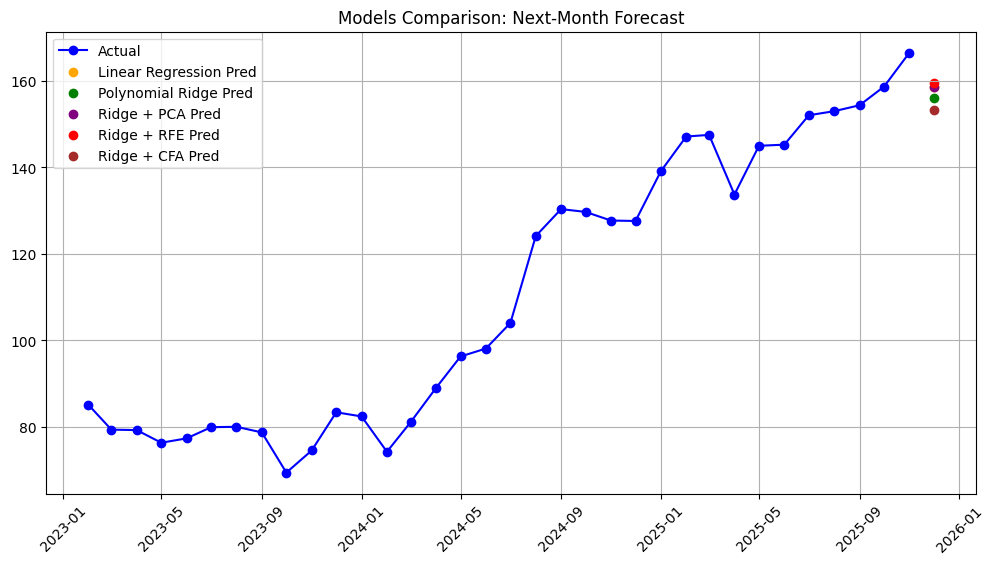

In [28]:
#Κελί 12: Γραφική παράσταση όλων των μοντέλων


import matplotlib.pyplot as plt
import pandas as pd


plt.figure(figsize=(12,6))

#Plot των πραγματικών μηνιαίων τιμών κλεισίματος
plt.plot(df_monthly['Date'], df_monthly['Close'], 
         marker='o', color='blue', label='Actual')

#Ορισμός χρωμάτων για κάθε μοντέλο για καλύτερη απεικόνιση
colors = {
    'Linear Regression': 'orange',
    'Polynomial Ridge': 'green',
    'Ridge + PCA': 'purple',
    'Ridge + RFE': 'red',
    'Ridge + CFA': 'brown'
}

#Plot των προβλέψεων για τον επόμενο μήνα (Ιανουάριος 2026)
#Χρησιμοποιούμε την τελευταία ημερομηνία του dataset και προσθέτουμε 1 μήνα
for m, vals in results.items():
    plt.scatter(df_monthly['Date'].iloc[-1] + pd.offsets.MonthBegin(),
                vals['Pred_Next'],
                color=colors[m],
                label=f"{m} Pred")
plt.xticks(rotation=45)
plt.title("Models Comparison: Next-Month Forecast")
plt.legend()
plt.grid(True)
plt.show()
